############################################ End-to-end Project by Patrick Mthisi ###################################
# FICO CREDIT CLASSIFICATION:

Data for the project was sourced from: https://community.fico.com/s/explainable-machine-learning-challenge

Competition Overview:

"The Explainable Machine Learning Challenge is a collaboration between Google, FICO and academics at Berkeley, Oxford, Imperial, UC Irvine and MIT, to generate new research in the area of algorithmic explainability. Teams will be challenged to create machine learning models with both high accuracy and explainability; they will use a real-world financial dataset provided by FICO. Designers and end users of machine learning algorithms will both benefit from more interpretable and explainable algorithms. Machine learning model designers will benefit from Model explanations, written explanations describing the functioning of a trained model. These might include information about which variables or examples are particularly important, they might explain the logic used by an algorithm, and/or characterize input/output relationships between variables and predictions. We expect teams to tell the story of their model such that these explanations will be qualitatively evaluated by data scientists at FICO." fico.

Home Equity Line of Credit (HELOC) Dataset:

This competition focuses on an anonymized dataset of Home Equity Line of Credit (HELOC) applications made by real homeowners. A HELOC is a line of credit typically offered by a bank as a percentage of home equity (the difference between the current market value of a home and its purchase price). The customers in this dataset have requested a credit line in the range of $5,000 - $150,000. The fundamental task is to use the information about the applicant in their credit report to predict whether they will repay their HELOC account within 2 years. This prediction is then used to decide whether the homeowner qualifies for a line of credit and, if so, how much credit should be extended. 

# 0. OBJECTIVES: 

In this project, we will explore a suilt data transformation techniques and machine learning algorithms that can used to develop intelling credit scoring systems. Particularly, we will explore the following:
- Exploring the credit scoring dataset.
- Data cleaning using a custom module which utilises mahalanobis distance to identify multivarite outliers.
- Feature extraction using factor analysis: 
     - Apply the Kaiser-Mecer-Oikin (KMO) test using a custom function; and
     - Use the Kaiser method to identify optimal number of factors.
- Framing the credit scoring problem, developing a test harness and evaluating the baseline model. 
- Exploring a suite of machine learning algorithms.
- Exploring ensembles techniqies to enhance performance.
- Selecting final model and saving file for deployment

# 1. Exploring the credit scoring dataset

In [360]:
# import revelant libraries
from collections import Counter
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from ydata_profiling import ProfileReport
import dtale
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from scipy.spatial.distance import mahalanobis
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator, TransformerMixin
import missingno as msno
from scipy import stats
from IPython.display import HTML
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import PowerTransformer
%matplotlib inline

# define data loaction 
filename = 'heloc_dataset_v1.csv'
# load csv as a dataframe
fico_dta = pd.read_csv(filename)
# For this project, we will remove special codes. However, this not advisable in the actual scorecard dwvelopment
special_codes = [-9, -8, -7]
fico_dta = fico_dta[fico_dta.apply(lambda x: x.apply(lambda y: y not in special_codes))]
# remove duplicate rows across all columns
fico_dta.drop_duplicates(inplace=True)
# create custom summary statistics function 
def disp_side_by_side(*dataframes):
    html = '<div style="display:flex">'
    for dataframe in dataframes:
        html += '<div style="margin-right: 2em">'
        html +=  dataframe.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))
    
#  define function perform univariate suammry statistics  
def summary_stats_analyzer(data):
    df1 = data.describe(include=['object', 'bool'])
    df2 = data.describe()
    return disp_side_by_side(df1, df2)

# summarise value counts and percentage of examples in each class
def summarise_target(data, target):
    # retrieve numpy array
    y = data.loc[:, target].values
    # summarise the value counts for each class label
    counter = Counter(y)
    # summarise class distribution
    print(counter)
    for k,v in counter.items():
        per = v / len(y) * 100
        print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))
        
# calculate Kaiser-Meyer-Oikin (KMO) to determine if factor analysis can be applied
def KMO_analyser(data):
    '''
    Perform Kaiser-Meyer-Olkin (KMO) analysis on the data.

    Parameters:
    data : pandas DataFrame
        Input DataFrame containing numerical variables.

    Raises:
    ValueError: If the KMO measure is less than 0.6.

    Returns:
    kmo_all : float
        KMO measure for all variables.
    kmo_model : float
        KMO measure for the model.
    '''
    df = data.select_dtypes(include=['float', 'int'])
    kmo_all, kmo_model = calculate_kmo(df)
    
    if kmo_model < 0.6:
        raise 
        ValueError("The KMO measure for the model is less than 0.6. Factor analysis may not be appropriate for this dataset.")
    return kmo_all, kmo_model

# define a module to calculated mahalanobis and replace outliers using interpolation method
class Mahalanobis_Outlier_Replace(BaseEstimator, TransformerMixin):
    def __init__(self, quantile_lower=0.25, quantile_upper=0.75, iqr_multiplier=1.5):
        self.quantile_lower = quantile_lower
        self.quantile_upper = quantile_upper
        self.iqr_multiplier = iqr_multiplier

    def fit(self, X, y=None):
        return self

    def transform(self, X, method='linear'):
        '''
        Replace outliers using Mahalanobis distance and interpolation.

        Parameters:
        X : Numpy array
            Input Numpy array containing numerical variables.
        method : str, default='linear'
            Method to use for interpolation.

        Returns:
        X_replaced : pandas DataFrame
            DataFrame with outliers replaced using interpolation.
        '''
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            
        numeric_columns = X.select_dtypes(include=['float', 'int']).columns
        df = X[numeric_columns]
        # convert columns names to string
        df.columns = df.columns.astype(str)
        numeric_columns = df.select_dtypes(include=['float', 'int']).columns
        df = df[numeric_columns]
        # scale the data to calculate distances
        scaled = StandardScaler().fit_transform(df)
        df_scaled = pd.DataFrame(scaled)
        # Calculate mean and covariance
        mean = df_scaled.mean()
        cov = df_scaled.cov()
        inv_cov = np.linalg.inv(cov)
        # Compute Mahalanobis distances
        distances = np.array([mahalanobis(r, mean, inv_cov) for _, r in df_scaled.iterrows()])
        df['mahalanobis_distance'] = distances
        # Calculate outlier thresholds
        q1 = df['mahalanobis_distance'].quantile(self.quantile_lower)
        q3 = df['mahalanobis_distance'].quantile(self.quantile_upper)
        iqr = q3 - q1
        lower = q1 - self.iqr_multiplier * iqr
        upper = q3 + self.iqr_multiplier * iqr
        # Filter outliers
        outliers = df[(df['mahalanobis_distance'] < lower) | (df['mahalanobis_distance'] > upper)]
        # drop mahalanobis_distance column
        df.drop(labels=['mahalanobis_distance'], axis=1, inplace=True)
        df_replaced = df.copy()
        # Replace outliers with NaN
        df_replaced.loc[outliers.index, numeric_columns] = np.nan
        # Interpolate NaN values
        df_replaced = df_replaced.interpolate(method=method)
        return df_replaced

In [361]:
# generate summary statistics
summary_stats_analyzer(fico_dta)

In [316]:
summarise_target(data=fico_dta, target='RiskPerformance')

Counter({'Bad': 5136, 'Good': 4736})
Class=Bad, Count=5136, Percentage=52.026%
Class=Good, Count=4736, Percentage=47.974%


In [ ]:
# perform automated EDA using pandas profiling:
fico_profile = ProfileReport(fico_dta)
fico_profile.to_file("fico_profile.html")

# 2. Data cleaning

In [317]:
# define data cleaning pipeline
steps = list()
steps.append(('impute', KNNImputer(n_neighbors=5)))
steps.append(('outlier_replacer', Mahalanobis_Outlier_Replace()))
data_cleaning_pipelie = Pipeline(steps=steps)
# remove target 
features = fico_dta.drop(labels='RiskPerformance', axis=1)
feature_names = features.columns
# commence data cleaning
features_cleaned = data_cleaning_pipelie.fit_transform(features)

In [318]:
fico_cleaned = pd.DataFrame(features_cleaned.values, columns=feature_names)
fico_cleaned['target'] = fico_dta['RiskPerformance'].values
fico_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9872 entries, 0 to 9871
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ExternalRiskEstimate                9872 non-null   float64
 1   MSinceOldestTradeOpen               9872 non-null   float64
 2   MSinceMostRecentTradeOpen           9872 non-null   float64
 3   AverageMInFile                      9872 non-null   float64
 4   NumSatisfactoryTrades               9872 non-null   float64
 5   NumTrades60Ever2DerogPubRec         9872 non-null   float64
 6   NumTrades90Ever2DerogPubRec         9872 non-null   float64
 7   PercentTradesNeverDelq              9872 non-null   float64
 8   MSinceMostRecentDelq                9872 non-null   float64
 9   MaxDelq2PublicRecLast12M            9872 non-null   float64
 10  MaxDelqEver                         9872 non-null   float64
 11  NumTotalTrades                      9872 no

In [319]:
# perform automated EDA using pandas profiling:
fico_profile_cleaned = ProfileReport(fico_cleaned)
fico_profile_cleaned.to_file("fico_profile_cleaned.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 3. Feature extraction using factor analysis

In [362]:
# cehck if factor analysis can be performed on the data
kmo_all, kmo_model = KMO_analyser(fico_cleaned)
kmo_model

0.7106934080488608

Optimal components: 7


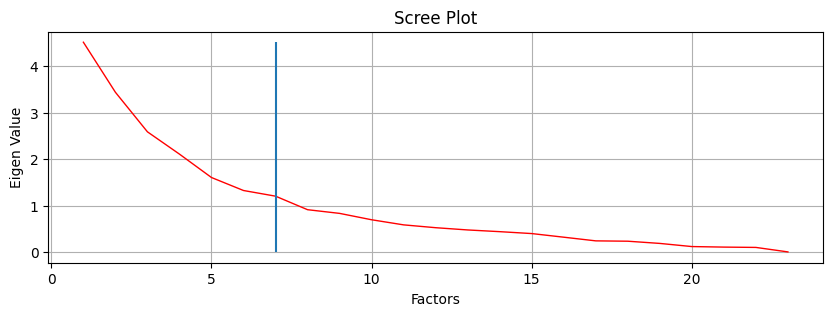

In [451]:
data = fico_cleaned.drop(labels='target', axis=1)
factors = data.shape[1]
# perform factor analysis
fa = FactorAnalyzer(rotation='varimax', n_factors=factors)
fa.fit(data)

ev, v = fa.get_eigenvalues()

factor_values = np.arange(1, factors + 1) 
# apply the Kaiser rule to indentify number of components where ev > 1
optimal_components = len(np.where(ev >= 1)[0])
print('Optimal components: %d' % optimal_components)
# plot screen plot
plt.figure(figsize=(10,3))
plt.plot(factor_values, ev, 'r-', linewidth=1)
plt.vlines(x=optimal_components, ymin=0, ymax=np.max(ev))
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()
plt.show()

In [452]:
fa = FactorAnalyzer(rotation='varimax', n_factors=optimal_components)
fa.fit(data)

loadings_output = pd.DataFrame(fa.loadings_, index=data.columns)
loadings_output.where(abs(loadings_output) > 0.5)

,0,1,2,3,4,5,6
ExternalRiskEstimate,NaN,NaN,-0.572148,NaN,0.617576,NaN,NaN
MSinceOldestTradeOpen,NaN,NaN,NaN,NaN,NaN,0.592627,NaN
MSinceMostRecentTradeOpen,NaN,NaN,NaN,NaN,NaN,0.514176,NaN
AverageMInFile,NaN,NaN,NaN,NaN,NaN,0.877723,NaN
NumSatisfactoryTrades,0.933625,NaN,NaN,NaN,NaN,NaN,NaN
NumTrades60Ever2DerogPubRec,NaN,0.956116,NaN,NaN,NaN,NaN,NaN
NumTrades90Ever2DerogPubRec,NaN,0.848140,NaN,NaN,NaN,NaN,NaN
PercentTradesNeverDelq,NaN,NaN,NaN,NaN,0.577228,NaN,NaN
MSinceMostRecentDelq,NaN,NaN,NaN,NaN,0.610023,NaN,NaN
MaxDelq2PublicRecLast12M,NaN,NaN,NaN,NaN,0.770421,NaN,NaN


In [453]:
# Get variance of each factors
factors = list()
for i in np.arange(1, optimal_components + 1):
    factor = 'factor'+ str(i)
    factors.append(factor)
# observe the cumulative variance explained by the optimal factors
pd.DataFrame(fa.get_factor_variance(), index=['SS Loadings', 'Proportion Var', 'Cumulative Var'], columns=factors)

,factor1,factor2,factor3,factor4,factor5,factor6,factor7
SS Loadings,2.524452,2.446351,2.315964,2.126995,2.031818,1.997009,1.267741
Proportion Var,0.109759,0.106363,0.100694,0.092478,0.088340,0.086826,0.055119
Cumulative Var,0.109759,0.216122,0.316816,0.409294,0.497634,0.584460,0.639580


In [454]:
c = fa.get_communalities()
sorted_communalities = pd.DataFrame(c, index=data.columns, columns=['Communalities']).apply(lambda x: x[np.argsort(-x)])
# Print sorted communalities DataFrame
print(sorted_communalities)

                                    Communalities
NumInqLast6Mexcl7days                    0.994530
NumInqLast6M                             0.988001
NumTrades60Ever2DerogPubRec              0.953017
ExternalRiskEstimate                     0.924545
NumSatisfactoryTrades                    0.883672
AverageMInFile                           0.831521
PercentInstallTrades                     0.780820
NumTrades90Ever2DerogPubRec              0.737687
NumTotalTrades                           0.732143
NetFractionRevolvingBurden               0.723238
MaxDelq2PublicRecLast12M                 0.699752
NumBank2NatlTradesWHighUtilization       0.654238
MaxDelqEver                              0.634780
NumRevolvingTradesWBalance               0.626371
PercentTradesWBalance                    0.608555
PercentTradesNeverDelq                   0.587926
MSinceOldestTradeOpen                    0.484590
NumTradesOpeninLast12M                   0.459013
NumInstallTradesWBalance                 0.402047


/tmp/ipykernel_8973/489897084.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



# 4. Developing a test harness and evaluating the baseline model


In [321]:
# develop a test harness, select the evaluation metric, and define a base model
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.dummy import DummyClassifier

# get the dataset
def load_data(data, target):
    # load data as numpy array
    df = data.copy()
    X = df[df.columns.difference([target])].values
    y = (df[target] == 'Bad').astype(int).values
    return X, y

# evaluate model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

# load the dataset
X, y = load_data(fico_cleaned, 'target')
# summarise the loaded dataset
print(X.shape, y.shape, Counter(y))
# define model
model = DummyClassifier(strategy='uniform')
# evaluate model
scores = evaluate_model(X, y, model)
#  report performance 
print('Mean ROC AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

(9872, 23) (9872,) Counter({1: 5136, 0: 4736})
Mean ROC AUC: 0.500 (0.000)


# 5. Evaluate a suite of machine learning algorithms

>LR 0.786 (0.014)
>LDA 0.786 (0.014)
>NB 0.768 (0.014)
>SVM 0.781 (0.017)
>BAG 0.762 (0.011)
>RF 0.777 (0.014)
>ET 0.778 (0.015)
>KNN 0.744 (0.016)


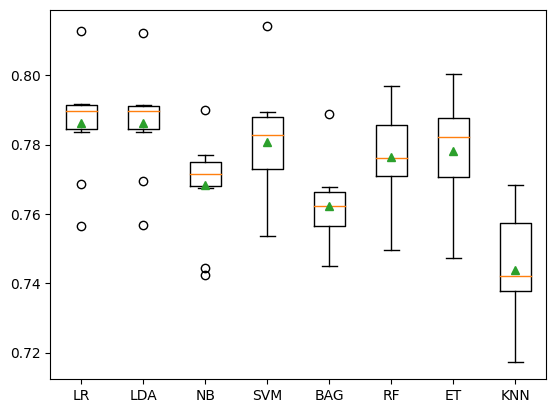

In [455]:
# evaluate machine learning algorithms 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

# define test models with default parameters
def get_models():
    # define models to evaluate
    models = dict()
    models['LR'] = LogisticRegression(solver='liblinear')
    models['LDA'] = LinearDiscriminantAnalysis()
    models['NB'] = GaussianNB()
    models['SVM'] = CalibratedClassifierCV(estimator=SVC(gamma='scale', probability=True), method='sigmoid', cv=3)
    models['BAG'] = CalibratedClassifierCV(estimator=BaggingClassifier(), method='sigmoid', cv=3)
    models['RF'] = CalibratedClassifierCV(estimator=RandomForestClassifier(), method='sigmoid', cv=3)
    models['ET'] = CalibratedClassifierCV(estimator=ExtraTreesClassifier(), method='sigmoid', cv=3)
    models['KNN'] = CalibratedClassifierCV(estimator=KNeighborsClassifier(), method='sigmoid', cv=3)
    return models

# get models to evaluate 
models = get_models()
# evaluate each model
names, results = list(), list()
for name, model in models.items():
    # wrap model in the pipeline
    steps = list()
    steps.append(('fa', FactorAnalyzer(rotation='varimax', n_factors=optimal_components)))
    steps.append(('model', model))
    pipeline = Pipeline(steps=steps)
    # evaluate model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    names.append(name)
    # summarise performance
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot performance results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# 6. Ensemble techniques to enhance performance
## 6.1 Voting ensemble

In [434]:
# select the top performing models
from sklearn.ensemble import VotingClassifier

# get voting ensemble of models
def get_voting():
    # define base models
    models = list()
    models.append(('LR', LogisticRegression(solver='liblinear')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('SVM', CalibratedClassifierCV(estimator=SVC(gamma='scale', probability=True), method='sigmoid', cv=3)))
    ensemble = VotingClassifier(estimators=models, voting='soft')
    return ensemble

# get model stacking model to evaluate
model = get_voting()
# evaluate model and print results
# wrap model in the pipeline
steps = list()
steps.append(('fa', FactorAnalyzer(rotation='varimax', n_factors=optimal_components)))
steps.append(('model', model))
pipeline = Pipeline(steps=steps) 
# evaluate model and store results
scores = evaluate_model(X, y, pipeline)
# summarise performance
print('>%s %.3f (%.3f)' % ('voting_ensemble', np.mean(scores), np.std(scores)))

>voting_ensemble 0.788 (0.014)


## 6.2 Stacking ensemble

In [435]:
# select top performing models but of difference types and perform stacking ensemble
from sklearn.ensemble import StackingClassifier
# get stacking ensemble of models
def get_stacking():
    # define base models
    level0 = list()
    level0.append(('LR', LogisticRegression(solver='liblinear')))
    level0.append(('LDA', LinearDiscriminantAnalysis()))
    level0.append(('SVM', CalibratedClassifierCV(estimator=SVC(gamma='scale', probability=True), method='sigmoid', cv=3)))
    # define meta-model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

# get model stacking model to evaluate
model = get_stacking()
# evaluate model and print results
# wrap model in the pipeline
steps = list()
steps.append(('fa', FactorAnalyzer(rotation='varimax', n_factors=optimal_components)))
steps.append(('model', model))
pipeline = Pipeline(steps=steps)
# evaluate model and store results
scores = evaluate_model(X, y, pipeline)
# summarise performance
print('>%s %.3f (%.3f)' % ('stacking_ensemble', np.mean(scores), np.std(scores)))

>stacking_ensemble 0.787 (0.014)


# 7. Final Model and saving for deployment

In [458]:
# fit the best performing model on the full dataset and save the model
import joblib

# get the dataset
def load_data(data, target):
    # load data as numpy array
    df = data.copy()
    X = df[df.columns.difference([target])].values
    y = (df[target] == 'Bad').astype(int).values
    return X, y


# get voting ensemble of models
def get_voting():
    # define base models
    models = list()
    models.append(('LR', LogisticRegression(solver='liblinear')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('SVM', CalibratedClassifierCV(estimator=SVC(gamma='scale', probability=True), method='sigmoid', cv=3)))
    ensemble = VotingClassifier(estimators=models, voting='soft')
    return ensemble

# load the dataset
X, y = load_data(fico_cleaned, 'target')
# get model stacking model to evaluate
model = get_voting()
# wrap the model in a future extraction pipeline 
steps = list()
steps.append(('fa', FactorAnalyzer(rotation='varimax', n_factors=optimal_components)))
steps.append(('model', model))
pipeline = Pipeline(steps=steps)
#  fit the model full dataset
pipeline.fit(X, y)
# define the name of the file
filename = "fico_credit_model.pkl"
# save model as pickle file
joblib.dump(pipeline, filename)

['fico_credit_model']